In [1]:
# Importing important packages
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-07-22 14:07:47--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.46.240, 142.250.189.208, 142.250.191.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.46.240|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: 'models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

     0K .......... .......... .......... .......... ..........  0% 2.20M 38s
    50K .......... .......... .......... .......... ..........  0% 2.75M 34s
   100K .......... .......... .......... .......... ..........  0% 1.94M 37s
   150K .......... .......... .......... .......... ..........  0% 6.99M 31s
   200K .......... .......... .......... .......... ..........  0% 2.10M 33s
   250K .......... .......... .......... .......... ......

In [8]:
from keras.layers import Dropout, Dense, Flatten, BatchNormalization, GlobalAveragePooling2D
from keras.models import Sequential
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

In [9]:
# Assigning the local weights that was downloaded
local_weights_file = 'models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [14]:
import os

data_dir = './animals/animals'

Name = os.listdir(data_dir)
print(Name)
print(len(Name))

N=list(range(len(Name)))
normal_mapping=dict(zip(Name,N)) 
reverse_mapping=dict(zip(N,Name)) 

['antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison', 'boar', 'butterfly', 'cat', 'caterpillar', 'chimpanzee', 'cockroach', 'cow', 'coyote', 'crab', 'crow', 'deer', 'dog', 'dolphin', 'donkey', 'dragonfly', 'duck', 'eagle', 'elephant', 'flamingo', 'fly', 'fox', 'goat', 'goldfish', 'goose', 'gorilla', 'grasshopper', 'hamster', 'hare', 'hedgehog', 'hippopotamus', 'hornbill', 'horse', 'hummingbird', 'hyena', 'jellyfish', 'kangaroo', 'koala', 'ladybugs', 'leopard', 'lion', 'lizard', 'lobster', 'mosquito', 'moth', 'mouse', 'octopus', 'okapi', 'orangutan', 'otter', 'owl', 'ox', 'oyster', 'panda', 'parrot', 'pelecaniformes', 'penguin', 'pig', 'pigeon', 'porcupine', 'possum', 'raccoon', 'rat', 'reindeer', 'rhinoceros', 'sandpiper', 'seahorse', 'seal', 'shark', 'sheep', 'snake', 'sparrow', 'squid', 'squirrel', 'starfish', 'swan', 'tiger', 'turkey', 'turtle', 'whale', 'wolf', 'wombat', 'woodpecker', 'zebra']
90


In [31]:
preprocess_input = tf.keras.applications.resnet.preprocess_input

batch_size=64

# Rescaling the input image as well as Data Augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
        validation_split=0.2,
        rotation_range=30,
        width_shift_range=0.2,
        preprocessing_function=preprocess_input,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255,validation_split=0.2)

data_dir = "./animals/animals"

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(255,255),
    class_mode='categorical',
  batch_size=120,subset = "training")

validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    target_size=(255,255),
    class_mode='categorical',
  batch_size=120,subset = "validation")


Found 4320 images belonging to 90 classes.
Found 1080 images belonging to 90 classes.


In [32]:
# Using the google Inception pretrained model for transfer learning
pre_trained_model = InceptionV3(input_shape = (255, 255, 3), 
                                include_top = False, 
                                weights = None)

# Loading the pre-trained weights that was downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

In [33]:
# printing out the summary of the pretrained model
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 255, 255, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 127, 127, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 127, 127, 32)         96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 127, 127, 32)         0         ['batch_normalizati

In [34]:
# getting the last layer from the pre_trained model to use for traning
last_layer = pre_trained_model.get_layer('mixed10')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 6, 6, 2048)


In [39]:
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(last_output)

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)  

x = layers.GlobalAveragePooling2D()(x)
# Flattening the model to 1 dimension
x = layers.Flatten()(x)

# Add a final sigmoid layer for classification
x = layers.Dense  (90, activation='softmax')(x)           

# Append the dense network to the base model
model = Model(pre_trained_model.input, x) 

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 255, 255, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 127, 127, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 127, 127, 32)         96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 127, 127, 32)         0         ['batch_normalization_94

In [40]:
# compiling the model
from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer = RMSprop(learning_rate=0.001), 
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics = ['accuracy'])

In [41]:
# defining the callback function
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Halts the training after training loss becomes less than 0.15

    Args:
      epoch (integer) - index of epoch (required but unused in the function definition below)
      logs (dict) - metric results from the training epoch
    '''

    # Check accuracy
    if(logs.get('loss') < 0.15):

      # Stop if threshold is met
      print("\nLoss is lower than 0.15 so cancelling training!")
      self.model.stop_training = True
    
# Instantiate class
callbacks = myCallback()

In [ ]:
# Fitting the model
history = model.fit(train_generator, epochs = 10, validation_data = validation_generator, callbacks = [callbacks])

Epoch 1/10
36/36 [==============================] - 199s 6s/step - loss: 0.4632 - accuracy: 0.8611 - val_loss: 0.5268 - val_accuracy: 0.8620
Epoch 2/10
13/36 [=========>....................] - ETA: 1:15 - loss: 0.4581 - accuracy: 0.8603

In [29]:
train_generator

In [43]:
# Saving the model.
model.save("AnimalClassification.h5")

C:\Users\seika\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


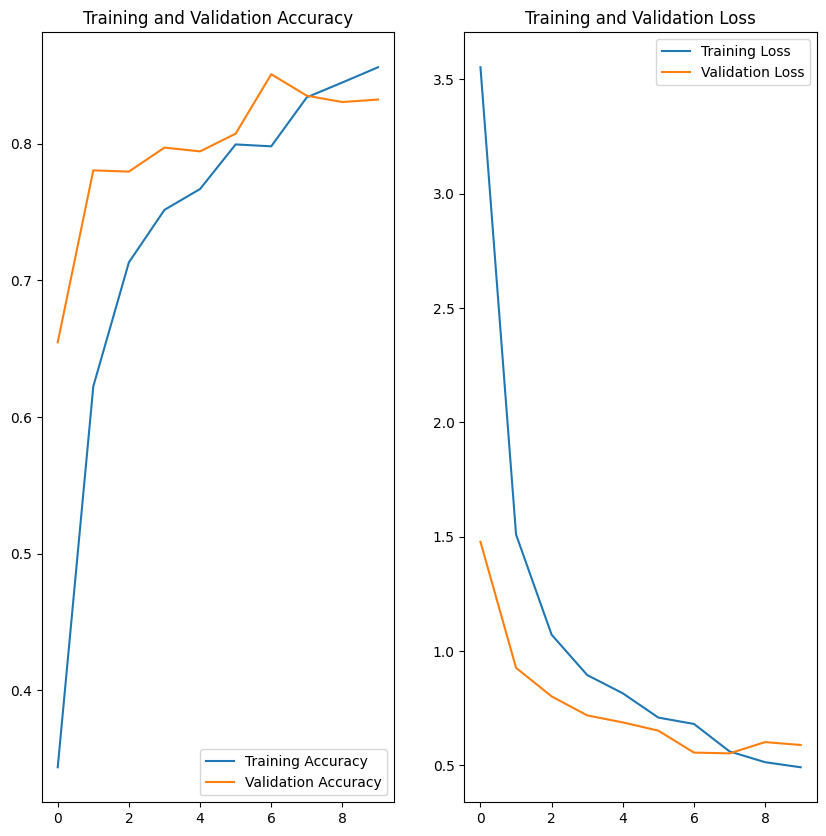

In [44]:
# Model Evaluation by comparing the training and validation accuracy as well as the loss.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [47]:
import cv2

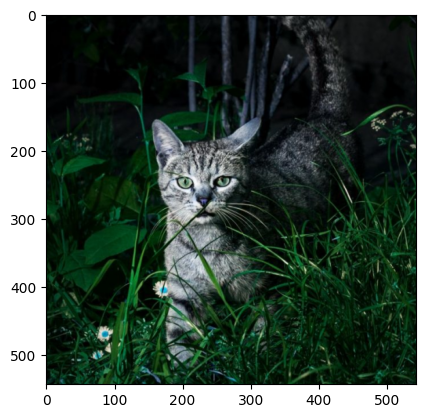

In [119]:
img = cv2.imread('tester8.png')
plt.imshow(img)
plt.show()

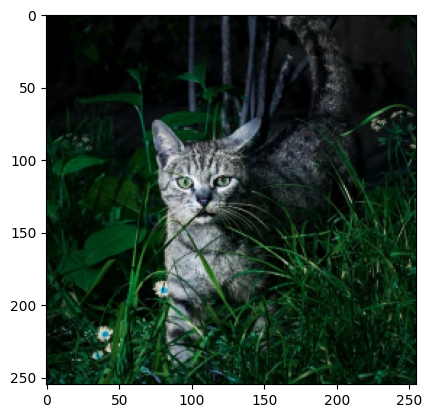

In [120]:
resize = tf.image.resize(img, (255,255))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [121]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 66ms/step


In [123]:
print(yhat[0, yhat.argmax()])
if yhat[0, yhat.argmax()] < 0.5:
    print('Uncertain')
Name[np.array(yhat).argmax()]

0.6134346


'cat'